In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TRADING_DAYS = 252

ticker = "SPY"
period = "10y"
alpha = 0.05          # VaR level (5%)
lambda_ewma = 0.94    # EWMA decay
rf_annual = 0.03      # (optional in this notebook)


In [18]:
import yfinance as yf

prices = yf.download(ticker, period=period, auto_adjust=True, progress=False)["Close"].dropna()
prices.tail()


Ticker,SPY
Date,
2026-01-26,692.729980
2026-01-27,695.489990
2026-01-28,695.419983
2026-01-29,694.039978
2026-01-30,691.969971


In [22]:
# Returns (force 1D Series) + integrity checks (non-blocking)
rets = prices.pct_change().dropna()

# If yfinance/Stooq returns a 1-col DataFrame, convert to Series
if isinstance(rets, pd.DataFrame):
    if rets.shape[1] == 1:
        rets = rets.iloc[:, 0]
    else:
        # if multiple columns appear, pick the first and warn
        print(f"Warning: returns has {rets.shape[1]} columns, using the first one.")
        rets = rets.iloc[:, 0]

rets = rets.astype(float).dropna()
rets.name = "r"

print("prices length:", len(prices))
print("rets length:", len(rets))
print("rets type:", type(rets), "shape:", rets.shape)

if len(rets) <= 300:
    print("Warning: Not many observations. Consider period='10y' or check data source/cache.")

rets.describe()



prices length: 2515
rets length: 2514
rets type: <class 'pandas.core.series.Series'> shape: (2514,)


count    2514.000000
mean        0.000636
std         0.011283
min        -0.109424
25%        -0.003529
50%         0.000729
75%         0.005932
max         0.105019
Name: r, dtype: float64

In [23]:
type(rets), getattr(rets, "shape", None)

(pandas.core.series.Series, (2514,))

In [24]:
split = int(len(rets) * 0.8)
r_train = rets.iloc[:split]
r_test = rets.iloc[split:]

len(r_train), len(r_test), r_train.index.min(), r_test.index.min()



(2011, 503, Timestamp('2016-02-02 00:00:00'), Timestamp('2024-01-30 00:00:00'))

In [25]:
def ewma_variance(r: pd.Series, lam: float) -> pd.Series:
    r = r.dropna()
    if len(r) < 10:
        raise ValueError(f"Not enough return observations for EWMA. Got {len(r)}.")

    r_arr = r.to_numpy(dtype=float)  # 1D
    r2 = r_arr ** 2

    var = np.zeros_like(r2, dtype=float)

    init_window = min(30, len(r_arr))
    var[0] = float(np.var(r_arr[:init_window], ddof=0))  # ddof=0 safe

    for t in range(1, len(r2)):
        var[t] = lam * var[t-1] + (1 - lam) * r2[t-1]

    return pd.Series(var, index=r.index, name="ewma_var")

ewma_var = ewma_variance(rets, lambda_ewma)
ewma_vol = np.sqrt(ewma_var).rename("ewma_vol")

ewma_vol.tail()


Date
2026-01-26    0.007212
2026-01-27    0.007102
2026-01-28    0.006955
2026-01-29    0.006743
2026-01-30    0.006556
Name: ewma_vol, dtype: float64

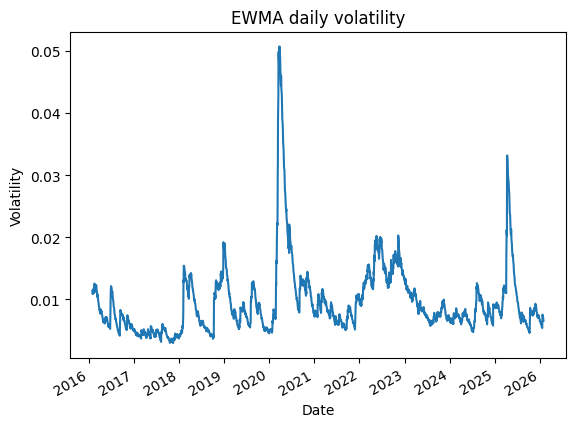

In [26]:
df_plot = pd.concat([rets.rename("returns"), ewma_vol], axis=1).dropna()

plt.figure()
df_plot["ewma_vol"].plot()
plt.title("EWMA daily volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.show()


In [28]:
from arch import arch_model

r_pct = 100 * rets  # percent scale
split_pct = int(len(r_pct) * 0.8)

am = arch_model(r_pct, mean="Zero", vol="GARCH", p=1, q=1, dist="t")
res = am.fit(disp="off", last_obs=split_pct)

res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Zero Mean - GARCH Model Results                           
====================================================================================
Dep. Variable:                            r   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2524.30
Distribution:      Standardized Student's t   AIC:                           5056.60
Method:                  Maximum Likelihood   BIC:                           5079.02
                                              No. Observations:                 2011
Date:                      Sun, Feb 01 2026   Df Residuals:                     2011
Time:                              18:01:56   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0174  5.810e-03      2.994  2.758e-03 [6.005e-03,2.878e-02]
alpha[1]       0.1683  2.635e-02      6.389  1.674e-10     [  0.117,  0.220]
beta[1]        0.8305  2.338e-02     35.521 2.353e-276     [  0.785,  0.876]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             5.7954      0.778      7.452  9.171e-14 [  4.271,  7.320]
========================================================================

Covariance estimator: robust
"""

In [29]:
f = res.forecast(horizon=1, start=split_pct, reindex=True)

# Variance forecast in percent^2
garch_var = f.variance["h.1"].dropna()

# Convert to decimal daily volatility
garch_vol = (np.sqrt(garch_var) / 100.0).rename("garch_vol")

# Align to test period
garch_vol_test = garch_vol.loc[r_test.index]
garch_vol_test.tail()



Date
2026-01-26    0.008342
2026-01-27    0.007887
2026-01-28    0.007307
2026-01-29    0.006837
2026-01-30    0.006485
Name: garch_vol, dtype: float64

<Figure size 640x480 with 0 Axes>

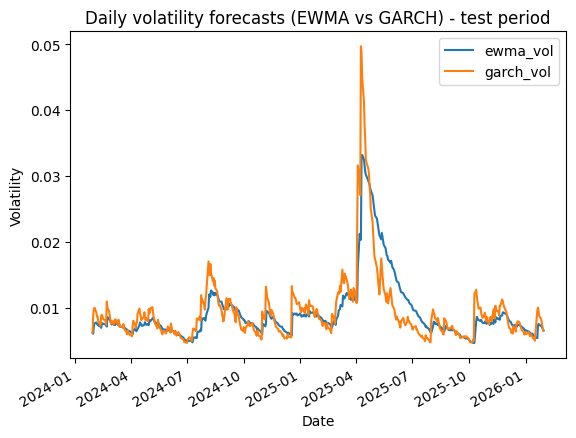

In [30]:
ewma_vol_test = ewma_vol.loc[r_test.index].rename("ewma_vol")
df_vol = pd.concat([ewma_vol_test, garch_vol_test], axis=1).dropna()

plt.figure()
df_vol.plot()
plt.title("Daily volatility forecasts (EWMA vs GARCH) - test period")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.savefig('efficient_frontier.png', dpi=300)
plt.show()


In [31]:
r_aligned = r_test.loc[df_vol.index]
realized_r2 = (r_aligned ** 2).rename("realized_r2")

mse_ewma = ((df_vol["ewma_vol"]**2 - realized_r2)**2).mean()
mse_garch = ((df_vol["garch_vol"]**2 - realized_r2)**2).mean()

pd.DataFrame({"MSE(var) vs r^2": [mse_ewma, mse_garch]}, index=["EWMA", "GARCH"])


,MSE(var) vs r^2
EWMA,2.871408e-07
GARCH,1.988889e-07


In [32]:
from scipy.stats import norm

def var_es_normal(vol: pd.Series, alpha: float, mu: float = 0.0):
    z = norm.ppf(alpha)
    var = -(mu + vol * z)
    es = -(mu + vol * norm.pdf(z) / alpha)
    return var.rename("VaR"), es.rename("ES")

r_aligned = r_test.loc[df_vol.index]

var_ewma, es_ewma = var_es_normal(df_vol["ewma_vol"], alpha, mu=0.0)
var_garch, es_garch = var_es_normal(df_vol["garch_vol"], alpha, mu=0.0)

var_ewma.tail(), var_garch.tail()


(Date
 2026-01-26    0.011863
 2026-01-27    0.011683
 2026-01-28    0.011440
 2026-01-29    0.011091
 2026-01-30    0.010783
 Name: VaR, dtype: float64,
 Date
 2026-01-26    0.013721
 2026-01-27    0.012972
 2026-01-28    0.012019
 2026-01-29    0.011246
 2026-01-30    0.010667
 Name: VaR, dtype: float64)

In [33]:
hits_ewma = (r_aligned < -var_ewma).astype(int).rename("hit_ewma")
hits_garch = (r_aligned < -var_garch).astype(int).rename("hit_garch")

pd.DataFrame({"hit_rate": [hits_ewma.mean(), hits_garch.mean()]}, index=["EWMA", "GARCH"])


,hit_rate
EWMA,0.057654
GARCH,0.031809


In [34]:
from math import log
from scipy.stats import chi2

def kupiec_test(hits: pd.Series, alpha: float):
    T = hits.shape[0]
    x = int(hits.sum())
    phat = x / T

    def safe_log(p):
        return log(p) if p > 0 else -1e12

    ll0 = (T - x) * safe_log(1 - alpha) + x * safe_log(alpha)
    ll1 = (T - x) * safe_log(1 - phat) + x * safe_log(phat)

    LR_uc = -2 * (ll0 - ll1)
    pval = 1 - chi2.cdf(LR_uc, df=1)

    return {"T": T, "violations": x, "hit_rate": phat, "LR_uc": LR_uc, "p_value": pval}

kupiec_test(hits_ewma, alpha), kupiec_test(hits_garch, alpha)


({'T': 503,
  'violations': 29,
  'hit_rate': 0.05765407554671968,
  'LR_uc': 0.5925029313398227,
  'p_value': np.float64(0.44145287956851675)},
 {'T': 503,
  'violations': 16,
  'hit_rate': 0.03180914512922465,
  'LR_uc': 4.001485360979814,
  'p_value': np.float64(0.04546018446519795)})

In [35]:
def christoffersen_independence_test(hits: pd.Series):
    h = hits.values.astype(int)
    n00 = np.sum((h[:-1] == 0) & (h[1:] == 0))
    n01 = np.sum((h[:-1] == 0) & (h[1:] == 1))
    n10 = np.sum((h[:-1] == 1) & (h[1:] == 0))
    n11 = np.sum((h[:-1] == 1) & (h[1:] == 1))

    p01 = n01 / (n00 + n01) if (n00 + n01) > 0 else 0.0
    p11 = n11 / (n10 + n11) if (n10 + n11) > 0 else 0.0
    p = (n01 + n11) / (n00 + n01 + n10 + n11) if (n00 + n01 + n10 + n11) > 0 else 0.0

    def safe_log(p):
        return np.log(p) if p > 0 else -1e12

    ll_ind = (
        n00 * safe_log(1 - p01) + n01 * safe_log(p01) +
        n10 * safe_log(1 - p11) + n11 * safe_log(p11)
    )
    ll_const = (
        (n00 + n10) * safe_log(1 - p) + (n01 + n11) * safe_log(p)
    )

    LR_ind = -2 * (ll_const - ll_ind)
    pval = 1 - chi2.cdf(LR_ind, df=1)
    return {"n00": int(n00), "n01": int(n01), "n10": int(n10), "n11": int(n11), "LR_ind": float(LR_ind), "p_value": float(pval)}

def christoffersen_cc_test(hits: pd.Series, alpha: float):
    kup = kupiec_test(hits, alpha)
    ind = christoffersen_independence_test(hits)
    LR_cc = kup["LR_uc"] + ind["LR_ind"]
    pval = 1 - chi2.cdf(LR_cc, df=2)
    return {"LR_cc": float(LR_cc), "p_value": float(pval), "kupiec": kup, "independence": ind}

christoffersen_cc_test(hits_ewma, alpha), christoffersen_cc_test(hits_garch, alpha)


({'LR_cc': 1.573329067441108,
  'p_value': 0.455361106690118,
  'kupiec': {'T': 503,
   'violations': 29,
   'hit_rate': 0.05765407554671968,
   'LR_uc': 0.5925029313398227,
   'p_value': np.float64(0.44145287956851675)},
  'independence': {'n00': 447,
   'n01': 26,
   'n10': 26,
   'n11': 3,
   'LR_ind': 0.9808261361012853,
   'p_value': 0.32199493155072545}},
 {'LR_cc': 4.400099075168129,
  'p_value': 0.11079766957751358,
  'kupiec': {'T': 503,
   'violations': 16,
   'hit_rate': 0.03180914512922465,
   'LR_uc': 4.001485360979814,
   'p_value': np.float64(0.04546018446519795)},
  'independence': {'n00': 471,
   'n01': 15,
   'n10': 15,
   'n11': 1,
   'LR_ind': 0.3986137141883148,
   'p_value': 0.5278060623071394}})